In [14]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from IPython.display import display
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import random
import torchinfo
from torchinfo import summary
import torchvision.models as models
from torch import optim
from torch.optim import lr_scheduler

In [31]:
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
train_dataset = ImageFolder('data/training_set/training_set/', transform = transform)
test_dataset = ImageFolder('data/test_set/test_set/', transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [32]:
class_names = train_dataset.classes

In [33]:
len(train_dataset)

8005

In [34]:
class_names

['cats', 'dogs']

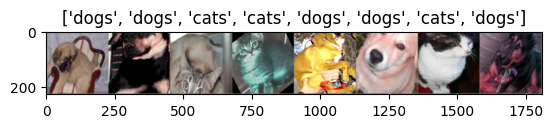

In [35]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [36]:

device = torch.device("cpu")
model_ft = models.vgg16(pretrained=True)

c:\Users\USER\.virtualenvs\bored_emotion_classifier-pq8v_Yyi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\.virtualenvs\bored_emotion_classifier-pq8v_Yyi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
for param in model_ft.features.parameters():
    param.requires_grad = False

num_features = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_features, 2)
device = torch.device("cpu")
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [39]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               scheduler):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        correct_predictions = (y_pred_class == y).sum().item()
        total_predictions = len(y_pred) 
        accuracy = correct_predictions / total_predictions
        train_acc += accuracy
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [40]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [43]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [44]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 24

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_ft.parameters(), lr=1e-3)

from timeit import default_timer as timer 
start_time = timer()

model_results = train(model=model_ft,
                      train_dataloader=train_loader,
                      test_dataloader=test_loader,
                      optimizer=optimizer_ft,
                      loss_fn=criterion,
                      epochs=NUM_EPOCHS,
                      scheduler=exp_lr_scheduler)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  4%|▍         | 1/24 [1:02:20<23:53:59, 3740.86s/it]

Epoch: 1 | train_loss: 0.4138 | train_acc: 0.8206 | test_loss: 0.3609 | test_acc: 0.8754


  8%|▊         | 2/24 [2:04:17<22:46:27, 3726.69s/it]

Epoch: 2 | train_loss: 0.4057 | train_acc: 0.8283 | test_loss: 0.3609 | test_acc: 0.8754


 12%|█▎        | 3/24 [3:07:09<21:51:34, 3747.36s/it]

Epoch: 3 | train_loss: 0.4105 | train_acc: 0.8223 | test_loss: 0.3609 | test_acc: 0.8754


 17%|█▋        | 4/24 [4:09:15<20:46:14, 3738.74s/it]

Epoch: 4 | train_loss: 0.4075 | train_acc: 0.8340 | test_loss: 0.3609 | test_acc: 0.8754


 21%|██        | 5/24 [5:11:42<19:44:51, 3741.68s/it]

Epoch: 5 | train_loss: 0.4047 | train_acc: 0.8293 | test_loss: 0.3609 | test_acc: 0.8754


 25%|██▌       | 6/24 [6:13:03<18:36:21, 3721.19s/it]

Epoch: 6 | train_loss: 0.4054 | train_acc: 0.8252 | test_loss: 0.3609 | test_acc: 0.8754


 29%|██▉       | 7/24 [7:14:23<17:30:29, 3707.61s/it]

Epoch: 7 | train_loss: 0.4111 | train_acc: 0.8260 | test_loss: 0.3609 | test_acc: 0.8754


 33%|███▎      | 8/24 [8:15:26<16:24:57, 3693.58s/it]

Epoch: 8 | train_loss: 0.4059 | train_acc: 0.8319 | test_loss: 0.3609 | test_acc: 0.8754


 38%|███▊      | 9/24 [9:16:32<15:21:13, 3684.92s/it]

Epoch: 9 | train_loss: 0.4079 | train_acc: 0.8260 | test_loss: 0.3609 | test_acc: 0.8754


 42%|████▏     | 10/24 [10:18:56<14:24:02, 3703.03s/it]

Epoch: 10 | train_loss: 0.4137 | train_acc: 0.8249 | test_loss: 0.3609 | test_acc: 0.8754


 46%|████▌     | 11/24 [11:21:16<13:24:48, 3714.48s/it]

Epoch: 11 | train_loss: 0.4067 | train_acc: 0.8264 | test_loss: 0.3609 | test_acc: 0.8754


 46%|████▌     | 11/24 [11:50:18<13:59:27, 3874.39s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(),"model/cat_dog_full_vgg_new_epoch.pth")
torch.save(model_ft.state_dict(),"model/cat_dog_full_vgg_newFT_epoch.pth")


In [21]:
import time
import copy

In [22]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataset_sizes = len(train_loader)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.3066 Acc: 7.0000
val Loss: 1.5522 Acc: 7.3000

Epoch 1/24
----------
train Loss: 1.8485 Acc: 7.1429
val Loss: 1.1081 Acc: 7.5286

Epoch 2/24
----------
train Loss: 1.5940 Acc: 7.4000
val Loss: 0.9893 Acc: 7.5857

Epoch 3/24
----------
train Loss: 1.4636 Acc: 7.3143
val Loss: 0.8936 Acc: 7.6143

Epoch 4/24
----------
train Loss: 1.5974 Acc: 7.4286
val Loss: 1.0072 Acc: 7.4286

Epoch 5/24
----------
train Loss: 1.2600 Acc: 7.4286
val Loss: 0.9773 Acc: 7.5571

Epoch 6/24
----------
train Loss: 1.2718 Acc: 7.4571
val Loss: 0.9570 Acc: 7.5571

Epoch 7/24
----------
train Loss: 1.2103 Acc: 7.5143
val Loss: 0.6269 Acc: 7.7000

Epoch 8/24
----------
train Loss: 0.7192 Acc: 7.6429
val Loss: 0.6268 Acc: 7.7571

Epoch 9/24
----------
train Loss: 0.8644 Acc: 7.5714
val Loss: 0.7881 Acc: 7.6571

Epoch 10/24
----------
train Loss: 0.8340 Acc: 7.6286
val Loss: 0.6047 Acc: 7.7429

Epoch 11/24
----------
train Loss: 0.7919 Acc: 7.6429
val Loss: 0.5606 Acc: 7.7714

Ep

In [24]:
torch.save(model_ft.state_dict(),"model/cat_dog_full_vgg_24_epoch.pth")

In [25]:
class ClassPredictor:
    def __init__(self,model,class_map) -> None:
        self.model = model
        self.class_map = class_map
    def preprocess(self,img_path):
        preprocess =transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor()
        ])
        image = Image.open(img_path).convert("RGB")
        image = preprocess(image)
        image = image.unsqueeze(0)
        return image
    def model_pred(self,img_tensor):
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
        _, pred_class = output.max(1)
        return self.class_map[pred_class.item()]
    def predict(self,img_path):
        img_tensor = self.preprocess(img_path=img_path)
        return self.model_pred(img_tensor=img_tensor)

In [26]:
class_map = {
    0:"cat",
    1:"dog"
}
pred_obj = ClassPredictor(model=model_ft,class_map=class_map)

In [29]:
img_path = 'data/cats_dogs/test/cats/cat_1.jpg'
pred_obj.predict(img_path)

'cat'

In [28]:
train_dataset.classes

['cats', 'dogs']